In [1]:

import tensorflow as tf

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.13.0


In [2]:
from keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import os
import pandas as pd
import numpy as np

In [3]:
# Get helper_functions.py script from course GitHub
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# Import helper functions we're going to use
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

--2023-09-30 18:33:37--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-09-30 18:33:37 (83.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



Downloading the Dataset

In [4]:
!pip install kaggle

In [5]:
from google.colab import files

# Upload the kaggle.json file
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [6]:
import os

# Move the kaggle.json file to the appropriate directory
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Set permissions for the kaggle.json file
!chmod 600 ~/.kaggle/kaggle.json


In [7]:
!kaggle datasets download -d jonathanoheix/face-expression-recognition-dataset

 94% 113M/121M [00:01<00:00, 91.6MB/s] 
100% 121M/121M [00:01<00:00, 85.2MB/s]


In [9]:
unzip_data("/content/face-expression-recognition-dataset.zip")

Data Preprocessing

In [10]:
TRAIN_DIR = '/content/images/train'
TEST_DIR = '/content/images/validation'

In [11]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+"/"+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder),1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img


Image shape: (48, 48)


array([[ 35,  40,  54, ...,  61,  83, 117],
       [ 37,  52,  61, ...,  63, 118, 187],
       [ 41,  53,  56, ...,  70, 158, 184],
       ...,
       [155, 121, 103, ...,  67,  72,  75],
       [ 90,  89,  82, ...,  70,  70,  71],
       [ 92,  95,  83, ...,  73,  73,  71]], dtype=uint8)

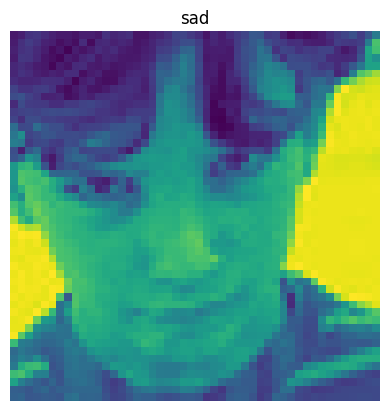

In [12]:
view_random_image(TRAIN_DIR,"sad")

In [13]:
def createdataframe(dir):
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        for imagename in os.listdir(os.path.join(dir,label)):
            image_paths.append(os.path.join(dir,label,imagename))
            labels.append(label)
        print(label, "completed")
    return image_paths,labels


In [14]:
train = pd.DataFrame()
train['image'], train['label'] = createdataframe(TRAIN_DIR)

happy completed
neutral completed
disgust completed
sad completed
surprise completed
fear completed
angry completed


In [15]:
print(train)

                                       image  label
0      /content/images/train/happy/21301.jpg  happy
1      /content/images/train/happy/20059.jpg  happy
2       /content/images/train/happy/5171.jpg  happy
3      /content/images/train/happy/25766.jpg  happy
4       /content/images/train/happy/6843.jpg  happy
...                                      ...    ...
28816   /content/images/train/angry/2381.jpg  angry
28817  /content/images/train/angry/20798.jpg  angry
28818  /content/images/train/angry/18360.jpg  angry
28819   /content/images/train/angry/1694.jpg  angry
28820  /content/images/train/angry/10907.jpg  angry

[28821 rows x 2 columns]


In [16]:
test = pd.DataFrame()
test['image'], test['label'] = createdataframe(TEST_DIR)

happy completed
neutral completed
disgust completed
sad completed
surprise completed
fear completed
angry completed


In [17]:
print(test)
print(test['image'])

                                           image  label
0      /content/images/validation/happy/8082.jpg  happy
1     /content/images/validation/happy/34102.jpg  happy
2     /content/images/validation/happy/18835.jpg  happy
3      /content/images/validation/happy/3278.jpg  happy
4        /content/images/validation/happy/80.jpg  happy
...                                          ...    ...
7061  /content/images/validation/angry/20287.jpg  angry
7062   /content/images/validation/angry/3802.jpg  angry
7063  /content/images/validation/angry/29980.jpg  angry
7064  /content/images/validation/angry/17502.jpg  angry
7065  /content/images/validation/angry/26572.jpg  angry

[7066 rows x 2 columns]
0        /content/images/validation/happy/8082.jpg
1       /content/images/validation/happy/34102.jpg
2       /content/images/validation/happy/18835.jpg
3        /content/images/validation/happy/3278.jpg
4          /content/images/validation/happy/80.jpg
                           ...                  

In [18]:
from tqdm.notebook import tqdm

In [19]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image,grayscale =  True )
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features),48,48,1)
    return features


In [20]:
train_features = extract_features(train['image'])

  0%|          | 0/28821 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/keras/src/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


In [21]:
test_features = extract_features(test['image'])

  0%|          | 0/7066 [00:00<?, ?it/s]

In [22]:
x_train = train_features/255.0
x_test = test_features/255.0

In [23]:
from sklearn.preprocessing import LabelEncoder

In [24]:
le = LabelEncoder()
le.fit(train['label'])

LabelEncoder()

In [25]:
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [26]:
y_train = to_categorical(y_train,num_classes = 7)
y_test = to_categorical(y_test,num_classes = 7)

Training the model

In [27]:
!pip install keras

In [28]:
import tensorflow.keras as keras

In [29]:
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import concatenate

In [30]:
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization

from keras.optimizers import Adam, SGD
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [31]:
from keras.callbacks import ModelCheckpoint
checkpoint_callback = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

In [33]:
    input_shape= (48, 48, 1)
    # Create input layer
    visible = Input(shape=input_shape, name='input')
    num_classes = 7
    #the 1-st block
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    conv1_1 = BatchNormalization()(conv1_1)
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)#the 2-nd block
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)#the 3-rd block
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)#the 4-th block
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)

    #the 5-th block
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_3)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)#Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)# create model
    model= Model(inputs =visible, outputs = ouput)
    model.compile(loss="categorical_crossentropy",optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
                metrics=["accuracy"])
    # summary layers


Train the model upto 70 epochs to get val accuracy upto 65%

In [34]:
model.fit(x= x_train,y = y_train, batch_size = 128, epochs = 1, validation_data = (x_test,y_test))

226/226 [==============================] - 61s 159ms/step - loss: 2.0820 - accuracy: 0.2062 - val_loss: 1.8563 - val_accuracy: 0.2583


In [38]:
label = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [39]:
def ef(image):
    img = load_img(image,grayscale =  True )
    feature = np.array(img)
    feature = feature.reshape(1,48,48,1)
    return feature/255.0


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

In [42]:
image = 'images/train/sad/42.jpg'
print("original image is of sad")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)

original image is of sad
1/1 [==============================] - 0s 18ms/step
model prediction is  happy


original image is of sad
1/1 [==============================] - 0s 55ms/step
model prediction is  sad


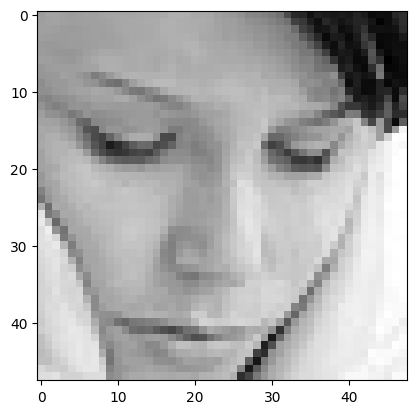

In [ ]:
image = 'images/train/sad/42.jpg'
print("original image is of sad")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of fear
1/1 [==============================] - 0s 31ms/step
model prediction is  sad


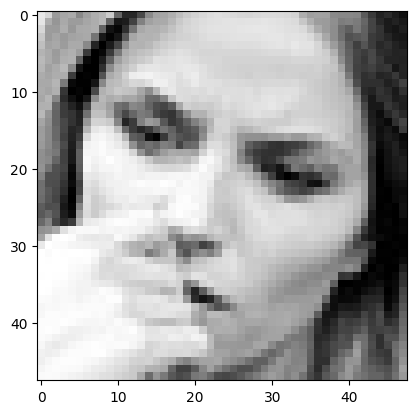

In [ ]:
image = 'images/train/fear/2.jpg'
print("original image is of fear")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of disgust
1/1 [==============================] - 0s 57ms/step
model prediction is  disgust


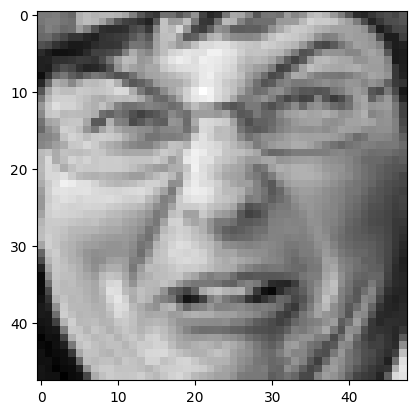

In [ ]:
image = 'images/train/disgust/299.jpg'
print("original image is of disgust")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of happy
1/1 [==============================] - 0s 42ms/step
model prediction is  happy


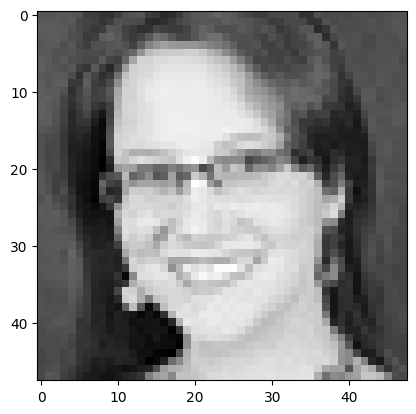

In [ ]:
image = 'images/train/happy/7.jpg'
print("original image is of happy")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of surprise
1/1 [==============================] - 0s 40ms/step
model prediction is  surprise


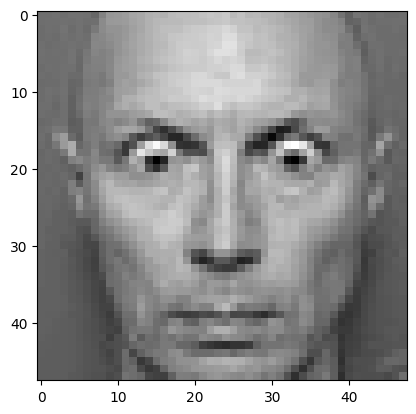

In [ ]:
image = 'images/train/surprise/15.jpg'
print("original image is of surprise")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

Saving and loading the model

In [35]:
model.save("FED.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
model_1= tf.keras.models.load_model('/content/FED.h5')